In [1]:
# import the library
%matplotlib inline

import ast
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler

import bokeh
import bokeh.plotting as plotting
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.tile_providers import CARTODBPOSITRON
plotting.output_notebook()

sns.set_style('whitegrid')

Loading BokehJS ...

# Problem definition

Cluster actors based on number of movies played, movie budget and populaity 

# Load the data

In [2]:
df = pd.read_csv('data/movies_new.csv')
df.head()

,id,title,budget,revenue,production_countries,release_date,popularity,vote_average,vote_count,genres,production_companies,belongs_to_collection,cast,keywords
0,36523,Felix The Cat: The Movie,9000000,1964253.0,"[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...",1988-10-01,0.030576,3.7,5.0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...","[{'name': 'Pannónia Filmstúdió', 'id': 48669},...",0,"[{'cast_id': 1, 'character': 'Felix the Cat (V...","[{'id': 9820, 'name': 'alternate dimension'}, ..."
1,68351,Sankofa,1000000,2691899.0,"[{'iso_3166_1': 'BF', 'name': 'Burkina Faso'},...",1993-05-28,0.045860,6.9,5.0,"[{'id': 18, 'name': 'Drama'}]","[{'name': 'Channel Four Films', 'id': 181}, {'...",0,"[{'cast_id': 6, 'character': 'Sankofa', 'credi...","[{'id': 409, 'name': 'africa'}, {'id': 2831, '..."
2,285908,The Last Breath,3800000,559298.0,"[{'iso_3166_1': 'CA', 'name': 'Canada'}]",1999-03-25,0.072704,4.0,2.0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...","[{'name': 'Lions Gate Films', 'id': 35}]",0,"[{'cast_id': 0, 'character': 'Lauren Vaillanco...","[{'id': 10714, 'name': 'serial killer'}]"
3,121173,Voracious,11178,34659.0,"[{'iso_3166_1': 'PH', 'name': 'Philippines'}]",2012-09-05,0.079287,8.0,1.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'name': 'APT Entertainment', 'id': 8355}, {'...",0,"[{'cast_id': 16, 'character': 'Rene', 'credit_...","[{'id': 4694, 'name': 'staged death'}, {'id': ..."
4,110669,Wabash Avenue,2115000,2039000.0,"[{'iso_3166_1': 'US', 'name': 'United States o...",1950-03-31,0.109913,7.0,1.0,"[{'id': 10402, 'name': 'Music'}]",[{'name': 'Twentieth Century Fox Film Corporat...,0,"[{'cast_id': 1004, 'character': 'Ruby Summers'...","[{'id': 4344, 'name': 'musical'}, {'id': 4497,..."


In [3]:
# #input
# df = pd.read_csv('data/interventionscitoyendo.csv', encoding='latin_1')
# df['DATE'] = pd.to_datetime(df['DATE'])
# print(df.columns)
# print(df['CATEGORIE'].value_counts())
# df.head()


#df = pd.read_csv('data/movies.csv')
df['release_date'] = pd.to_datetime(df['release_date'])
df['year'] = df['release_date'].dt.year
print(df.dtypes)

#Setting cast, production_companies, genres and keywords types to a list of dictionaries

df['cast'] = df['cast'].astype(str)
df['production_countries'] = df['production_countries'].astype(str)
df['genres'] = df['genres'].astype(str)
# df['production_companies'] = df['production_companies'].astype(str)

df['genres'] = df['genres'].apply(lambda x: ast.literal_eval(x))
# df['production_companies'] = df['production_companies'].apply(lambda x: ast.literal_eval(x))
df['cast'] = df['cast'].apply(lambda x: ast.literal_eval(x))
df['production_countries'] = df['production_countries'].apply(lambda x: ast.literal_eval(x))

id                                int64
title                            object
budget                            int64
revenue                         float64
production_countries             object
release_date             datetime64[ns]
popularity                      float64
vote_average                    float64
vote_count                      float64
genres                           object
production_companies             object
belongs_to_collection            object
cast                             object
keywords                         object
year                              int64
dtype: object


Choosing columns

In [4]:
df = df[['title', 'budget', 'year', 'revenue', 'cast', 'production_countries', 'vote_average', 'vote_count', 'genres']].copy()
print(df.head(5))

                      title   budget  year    revenue  \
0  Felix The Cat: The Movie  9000000  1988  1964253.0   
1                   Sankofa  1000000  1993  2691899.0   
2           The Last Breath  3800000  1999   559298.0   
3                 Voracious    11178  2012    34659.0   
4             Wabash Avenue  2115000  1950  2039000.0   

                                                cast  \
0  [{'cast_id': 1, 'character': 'Felix the Cat (V...   
1  [{'cast_id': 6, 'character': 'Sankofa', 'credi...   
2  [{'cast_id': 0, 'character': 'Lauren Vaillanco...   
3  [{'cast_id': 16, 'character': 'Rene', 'credit_...   
4  [{'cast_id': 1004, 'character': 'Ruby Summers'...   

                                production_countries  vote_average  \
0  [{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...           3.7   
1  [{'iso_3166_1': 'BF', 'name': 'Burkina Faso'},...           6.9   
2           [{'iso_3166_1': 'CA', 'name': 'Canada'}]           4.0   
3      [{'iso_3166_1': 'PH', 'name': 'Ph

# Feature Engineering 

Select a period

In [5]:
df = df[(df['year']>=2000)]
del df['year']
print(df.shape)

(3112, 8)


Keeping only movies which were produced in USA as the budget might be marked in US although in reality its not

In [6]:
df.reset_index(drop=True, inplace=True)
index_extractor = lambda df, field, value: [idx for idx, entries in enumerate(df[field]) for item in entries if value in item['name']]
list_creator = lambda df, idx: [1 if i in idx else 0 for i in df.index]

#Extracting list of countries
l=[]
for i, item in enumerate(df['production_countries']):
    for cell in item:
        l.append(cell['name'])
p_name, p_count = np.unique(np.array(l), return_counts=True)

prod = zip(p_name, p_count) # list of Unique Values along with occurrence Count
prod = list(prod)
prod = sorted(prod, key = lambda x: x[1], reverse = True)
print('Number of production countries: ', len(prod))

df = df.iloc[index_extractor(df, 'production_countries', 'United States of America'),:]
del df['production_countries']
print(df.shape)

Number of production countries:  68
(2522, 7)


In [7]:
df.head(5)

,title,budget,revenue,cast,vote_average,vote_count,genres
10,Cruel World,2000000,16344.0,"[{'cast_id': 1, 'character': 'Philip Markham',...",4.8,6.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 27, 'n..."
19,Behind the Burly Q,250000,23859.0,"[{'cast_id': 2, 'character': '. Himself (arc...",5.5,3.0,"[{'id': 99, 'name': 'Documentary'}]"
20,The Internship,58000000,44000000.0,"[{'cast_id': 7, 'character': 'Nick Campbell', ...",6.1,1691.0,"[{'id': 35, 'name': 'Comedy'}]"
21,Resident Evil: Afterlife,60000000,300228084.0,"[{'cast_id': 11, 'character': 'Alice', 'credit...",5.8,1382.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam..."
22,Eye of the Dolphin,2500000,71904.0,"[{'cast_id': 1, 'character': 'Alyssa', 'credit...",7.1,7.0,"[{'id': 18, 'name': 'Drama'}]"


In [8]:
df.reset_index(inplace=True, drop=True)
index_extractor = lambda df, field, value: [idx for idx, entries in enumerate(df[field]) for item in entries if value == item['name']]
list_creator = lambda df, idx: [1 if i in idx else 0 for i in df.index]

#Extracting list of genres
l=[]
for i, item in enumerate(df['genres']):
    for cell in item:
        l.append(cell['name'])
g_name, g_count = np.unique(np.array(l), return_counts=True)

Extract Actors

In [9]:
df.reset_index(drop=True, inplace=True)
#Extracting list of actors
l = []

for i, item in enumerate(df['cast']):
    for cell in item:
        l.append(cell['name'])
       
    a_name, a_count = np.unique(np.array(l), return_counts=True)

idx=[]
for i, item  in enumerate(a_name):
    if (item == 'Kar') | (item == 'George') | (a_name[i] == 'Mario') | (a_name[i] == 'Jack') | (a_name[i] == 'Charle') | (a_name[i] == 'Charlie') | (a_name[i] == 'Mars') | (a_name[i] == 'Terry') | (a_name[i] == 'King') | (a_name[i] == 'Sim') | (a_name[i] == 'Elli') | (a_name[i] == 'Carlos') | (a_name[i] == 'Sandra') | (a_name[i] == 'Justin') | (a_name[i] == 'Shane') | (a_name[i] == 'Angela') | (a_name[i] == 'Eve') | (a_name[i] == 'Foster') | (a_name[i] == 'Take') | (a_name[i] == 'Andrea') | (a_name[i] == 'Ade') | (a_name[i] == 'Tiffany') | (a_name[i] == 'Zoë'):
        idx.append(i)


# for item in zip(a_name, a_count):
#     if item[0] == "Cher'":
#         print(item[0], item[1])

    
a_name = np.delete(a_name, idx)
a_count = np.delete(a_count, idx)
df.reset_index(drop=True, inplace=True)
print('number of actors: ', len(a_name))

# Creating lists of features for each actor
print('Creating lists of features for each actor')
index_extractor = lambda df, field, value: [idx for idx, entries in enumerate(df[field]) for item in entries if value == item['name']]
list_rev_creator =  lambda df, idx: [df.loc[i,'revenue'] if i in idx else 0 for i in df.index] # List of revenues for current actor
list_pop_creator =  lambda df, idx: [df.loc[i,'vote_count'] if i in idx else 0 for i in df.index] # List of popularities for current actor
list_vote_creator =  lambda df, idx: [df.loc[i,'vote_average'] if i in idx else 0 for i in df.index]
list_bud_creator =  lambda df, idx: [df.loc[i,'budget'] if i in idx else 0 for i in df.index]


a_rev = []
a_pop = []
a_rev_sum = []
a_pop_sum = []
a_vote = []
a_vote_sum = []
a_bud = []
a_bud_sum = []

for actor, count in zip(a_name, a_count):
    idx = index_extractor(df, 'cast', actor)

    actor_rev = list_rev_creator(df, idx)   
    a_rev.append(np.sum(actor_rev)/count) 
    a_rev_sum.append(np.sum(actor_rev)) 

    actor_pop = list_pop_creator(df, idx)   
    a_pop.append(np.sum(actor_pop)/count)    
    a_pop_sum.append(np.sum(actor_pop))    

    actor_vote = list_vote_creator(df, idx)   
    a_vote.append(np.sum(actor_vote)/count)    
    a_vote_sum.append(np.sum(actor_vote))

    actor_bud = list_bud_creator(df, idx)   
    a_bud.append(np.sum(actor_bud)/count)    
    a_bud_sum.append(np.sum(actor_bud))

print('finished')

number of actors:  36856
Creating lists of features for each actor
finished


Refactor our Dataframe to be presented by its actors

In [10]:
print(type(a_name), type(a_count), type(a_rev))

a_name_s = pd.Series(a_name)
a_count_s = pd.Series(a_count)
a_rev_s =  pd.Series(a_rev)
a_rev_sum_s = pd.Series(a_rev_sum)
a_pop_s = pd.Series(a_pop)

a_pop_sum_s = pd.Series(a_pop_sum)
a_vote_s = pd.Series(a_vote)
a_vote_sum_s = pd.Series(a_vote_sum)
a_bud_s = pd.Series(a_bud)
a_bud_sum_s = pd.Series(a_bud_sum)

df_act = a_name_s.to_frame()

df_act = df_act.assign(a_count_s=a_count_s.values)
df_act = df_act.assign(a_rev_s=a_rev_s.values)
df_act = df_act.assign(a_rev_sum_s=a_rev_sum_s.values)
df_act = df_act.assign(a_pop_s=a_pop_s.values)
df_act = df_act.assign(a_pop_sum_s=a_pop_sum_s.values)
df_act = df_act.assign(a_vote_s=a_vote_s.values)
df_act = df_act.assign(a_vote_sum_s=a_vote_sum_s.values)
df_act = df_act.assign(a_bud_s=a_bud_s.values)
df_act = df_act.assign(a_bud_sum_s=a_bud_sum_s.values)

df_act.rename(columns={0:'name'}, inplace=True)
df_act.rename(columns={'a_count_s':'num_movies'}, inplace=True)
df_act.rename(columns={'a_rev_s':'ave_revenue'}, inplace=True)
df_act.rename(columns={'a_rev_sum_s':'sum_revenue'}, inplace=True)
df_act.rename(columns={'a_bud_s':'ave_budget'}, inplace=True)
df_act.rename(columns={'a_bud_sum_s':'sum_budget'}, inplace=True)
df_act.rename(columns={'a_pop_s':'ave_count_vote'}, inplace=True)
df_act.rename(columns={'a_pop_sum_s':'sum_count_vote'}, inplace=True)
df_act.rename(columns={'a_vote_s':'ave_vote'}, inplace=True)
df_act.rename(columns={'a_vote_sum_s':'sum_ave_votes'}, inplace=True)

df_act.head(10)


<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'list'>


,name,num_movies,ave_revenue,sum_revenue,ave_count_vote,sum_count_vote,ave_vote,sum_ave_votes,ave_budget,sum_budget
0,"""Weird Al"" Yankovic",1,3.942147e+07,3.942147e+07,273.000000,273.0,5.100000,5.1,1.500000e+07,15000000
1,'Sister' Carol East,1,4.132533e+07,4.132533e+07,273.000000,273.0,5.600000,5.6,1.800000e+07,18000000
2,50 Cent,11,9.472218e+07,1.041944e+09,841.545455,9257.0,6.054545,66.6,3.620182e+07,398220000
3,A. Cheron Hall,1,3.000000e+07,3.000000e+07,154.000000,154.0,5.600000,5.6,2.500000e+07,25000000
4,A. David Burleigh,1,1.237241e+07,1.237241e+07,51.000000,51.0,4.700000,4.7,2.400000e+07,24000000
5,A. Frank Ruffo,2,5.053966e+07,1.010793e+08,501.000000,1002.0,6.150000,12.3,2.900000e+07,58000000
6,A. J. Benza,1,1.557211e+08,1.557211e+08,858.000000,858.0,6.500000,6.5,2.400000e+07,24000000
7,A. Jay Radcliff,1,2.045940e+08,2.045940e+08,655.000000,655.0,5.800000,5.8,6.000000e+07,60000000
8,A. P. Singh,1,2.437715e+07,2.437715e+07,876.000000,876.0,7.100000,7.1,1.600000e+07,16000000
9,A. Russell Andrews,2,1.281675e+08,2.563351e+08,1083.500000,2167.0,6.900000,13.8,3.050000e+07,61000000


In [11]:
# Create column for every genre and assigh all 0
print(len(g_name))
for genre in g_name:
    genre_col = pd.Series(np.zeros(len(df_act))) 
    df_act = df_act.assign(genre_col=genre_col.values)
    df_act.rename(columns={'genre_col':'{0}'.format(genre)}, inplace=True)
df_act.head(5)

19


,name,num_movies,ave_revenue,sum_revenue,ave_count_vote,sum_count_vote,ave_vote,sum_ave_votes,ave_budget,sum_budget,...,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
0,"""Weird Al"" Yankovic",1,3.942147e+07,3.942147e+07,273.000000,273.0,5.100000,5.1,1.500000e+07,15000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,'Sister' Carol East,1,4.132533e+07,4.132533e+07,273.000000,273.0,5.600000,5.6,1.800000e+07,18000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,50 Cent,11,9.472218e+07,1.041944e+09,841.545455,9257.0,6.054545,66.6,3.620182e+07,398220000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A. Cheron Hall,1,3.000000e+07,3.000000e+07,154.000000,154.0,5.600000,5.6,2.500000e+07,25000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A. David Burleigh,1,1.237241e+07,1.237241e+07,51.000000,51.0,4.700000,4.7,2.400000e+07,24000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
df.reset_index(drop=True, inplace=True)
df_act.reset_index(drop=True, inplace=True)

index_extractor = lambda df, field, value: [idx for idx, entries in enumerate(df[field]) for item in entries if value == item['name']]

def list_gen_creator(df, idx):
    g = []
    for i in df.index:
        if i in idx:
            for item in df.loc[i,'genres']:
                g.append(item['name'])
    return np.unique(np.array(g), return_counts=True)

for index in df_act.index:
    idx = index_extractor(df, 'cast', df_act.loc[index, 'name']) # list of indexes of movies with specific actor
    g_n, g_c = list_gen_creator(df, idx) # arrays of genres and number of movies in which this ctor played
    for genre, count in zip(g_n, g_c):
        df_act.loc[index, genre] = count # assigning number of movies into the genre column for each actor

df_act.head(20)


,name,num_movies,ave_revenue,sum_revenue,ave_count_vote,sum_count_vote,ave_vote,sum_ave_votes,ave_budget,sum_budget,...,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
0,"""Weird Al"" Yankovic",1,3.942147e+07,3.942147e+07,273.000000,273.0,5.100000,5.1,1.500000e+07,15000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,'Sister' Carol East,1,4.132533e+07,4.132533e+07,273.000000,273.0,5.600000,5.6,1.800000e+07,18000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,50 Cent,11,9.472218e+07,1.041944e+09,841.545455,9257.0,6.054545,66.6,3.620182e+07,398220000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6.0,0.0,0.0
3,A. Cheron Hall,1,3.000000e+07,3.000000e+07,154.000000,154.0,5.600000,5.6,2.500000e+07,25000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A. David Burleigh,1,1.237241e+07,1.237241e+07,51.000000,51.0,4.700000,4.7,2.400000e+07,24000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,A. Frank Ruffo,2,5.053966e+07,1.010793e+08,501.000000,1002.0,6.150000,12.3,2.900000e+07,58000000,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
6,A. J. Benza,1,1.557211e+08,1.557211e+08,858.000000,858.0,6.500000,6.5,2.400000e+07,24000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,A. Jay Radcliff,1,2.045940e+08,2.045940e+08,655.000000,655.0,5.800000,5.8,6.000000e+07,60000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,A. P. Singh,1,2.437715e+07,2.437715e+07,876.000000,876.0,7.100000,7.1,1.600000e+07,16000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,A. Russell Andrews,2,1.281675e+08,2.563351e+08,1083.500000,2167.0,6.900000,13.8,3.050000e+07,61000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Coose columns

In [55]:
# ['num_movies', 'ave_revenue', 'sum_revenue', 'ave_count_vote', 'sum_count_vote', 'ave_vote', 'sum_ave_votes', 'ave_budget', 'sum_budget']
# ['num_movies', 'ave_revenue', 'ave_count_vote', 'ave_vote', 'ave_budget']
analize_columns = list(df_act.columns)
for col in ['name','sum_revenue','sum_count_vote', 'sum_ave_votes','sum_budget']:
    analize_columns.remove(col)
X_columns =  ['num_movies', 'ave_revenue', 'ave_count_vote', 'ave_vote', 'ave_budget']
X = df_act[X_columns]
X.head()

,num_movies,ave_revenue,ave_count_vote,ave_vote,ave_budget
0,1,3.942147e+07,273.000000,5.100000,1.500000e+07
1,1,4.132533e+07,273.000000,5.600000,1.800000e+07
2,11,9.472218e+07,841.545455,6.054545,3.620182e+07
3,1,3.000000e+07,154.000000,5.600000,2.500000e+07
4,1,1.237241e+07,51.000000,4.700000,2.400000e+07


### Normalize

In [46]:
# normalize the data
for col in X_columns:
    X[col] = StandardScaler().fit_transform(X[col].values.reshape(-1, 1))

C:\Users\Anastasia\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Anastasia\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Anastasia\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Anastasia\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [47]:
X.head()


,num_movies,ave_revenue,ave_count_vote,ave_vote,ave_budget
0,-0.360773,-0.591989,-0.732598,-1.614793,-0.814995
1,-0.360773,-0.584918,-0.732598,-0.962942,-0.759687
2,3.635213,-0.386609,-0.442470,-0.370349,-0.424121
3,-0.360773,-0.626979,-0.793323,-0.962942,-0.630636
4,-0.360773,-0.692446,-0.845884,-2.136274,-0.649072


In [48]:
X.shape

(36856, 5)

# Model Training

In [49]:
# model = DBSCAN(eps=0.5, min_samples=200)

k = 4
model = KMeans(n_clusters=k).fit(X[X_columns]) 
model.fit(X[X_columns])

cluster_labels = model.labels_
n_clusters = len(set(cluster_labels))

print(collections.Counter(cluster_labels))

X['cluster'] = cluster_labels


Counter({0: 15323, 1: 14913, 2: 5213, 3: 1407})


C:\Users\Anastasia\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [50]:
df_results = df_act.copy()
df_results['cluster'] = cluster_labels
df_results.sort_values('cluster', ascending=False)

,name,num_movies,ave_revenue,sum_revenue,ave_count_vote,sum_count_vote,ave_vote,sum_ave_votes,ave_budget,sum_budget,...,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western,cluster
13708,Hiroyuki Sanada,8,3.330526e+08,2.664421e+09,2058.875000,16471.0,6.375000,51.0,1.096250e+08,877000000,...,1.0,1.0,0.0,0.0,0.0,4.0,3.0,1.0,0.0,3
9446,Dev Patel,7,1.662762e+08,1.163933e+09,1393.857143,9757.0,6.357143,44.5,3.550000e+07,248500000,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3
32892,Stephen Kearin,9,4.877221e+08,4.389499e+09,1847.555556,16628.0,6.577778,59.2,1.435556e+08,1292000000,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3
29664,Robert Capron,7,6.825743e+07,4.778020e+08,656.428571,4595.0,6.185714,43.3,2.471429e+07,173000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
32899,Stephen Lang,7,4.708622e+08,3.296035e+09,2408.142857,16857.0,6.142857,43.0,7.884286e+07,551900000,...,2.0,1.0,0.0,0.0,0.0,1.0,2.0,2.0,0.0,3
2291,Anna Kendrick,20,2.100082e+08,4.200165e+09,1482.150000,29643.0,6.400000,128.0,3.934000e+07,786800000,...,0.0,0.0,3.0,0.0,8.0,0.0,2.0,0.0,0.0,3
17494,John Travolta,13,1.163406e+08,1.512427e+09,646.769231,8408.0,5.746154,74.7,6.615385e+07,860000000,...,0.0,0.0,1.0,2.0,1.0,2.0,6.0,1.0,0.0,3
17498,John Turturro,18,2.859001e+08,5.146203e+09,1279.277778,23027.0,5.877778,105.8,9.994444e+07,1799000000,...,1.0,0.0,0.0,1.0,1.0,4.0,5.0,1.0,0.0,3
32917,Stephen McHattie,8,1.909114e+08,1.527291e+09,1992.750000,15942.0,6.450000,51.6,6.562500e+07,525000000,...,0.0,1.0,0.0,1.0,2.0,4.0,3.0,1.0,0.0,3
9384,Derek Mears,11,2.539308e+08,2.793239e+09,1900.181818,20902.0,5.927273,65.2,1.010909e+08,1112000000,...,0.0,3.0,0.0,0.0,0.0,4.0,2.0,0.0,0.0,3


In [51]:
# Analyze the results
for cluster in set(cluster_labels):
    print((cluster), (len(df_results[df_results['cluster']==cluster]['name'])))
#     print(sorted(list(df_results[df_results['cluster']==cluster]['Country'])))

# Analyze the centroids
df_results.groupby('cluster').mean().round(2).T

0 15323
1 14913
2 5213
3 1407


cluster,0,1,2,3
num_movies,1.580000e+00,1.450000e+00,1.430000e+00,1.199000e+01
ave_revenue,9.407870e+07,1.284011e+08,7.107378e+08,1.892193e+08
sum_revenue,1.612083e+08,2.044097e+08,9.795598e+08,2.320553e+09
ave_count_vote,7.309400e+02,1.484240e+03,5.284290e+03,1.486440e+03
sum_count_vote,1.246550e+03,2.257060e+03,7.110240e+03,1.820677e+04
ave_vote,5.660000e+00,6.850000e+00,6.890000e+00,6.250000e+00
sum_ave_votes,9.020000e+00,9.850000e+00,9.820000e+00,7.506000e+01
ave_budget,4.464748e+07,3.925552e+07,1.588574e+08,6.002834e+07
sum_budget,7.169583e+07,6.261837e+07,2.195689e+08,7.347916e+08
Action,5.300000e-01,3.200000e-01,8.800000e-01,3.660000e+00


[(1, 10774), (2, 2355), (3, 1059), (4, 504), (5, 343)]
[(1, 11157), (2, 2129), (3, 839), (4, 383), (5, 255)]
[(1, 3973), (2, 726), (3, 263), (4, 129), (5, 59)]
[(7, 245), (8, 219), (9, 187), (10, 126), (11, 92)]
num_movies


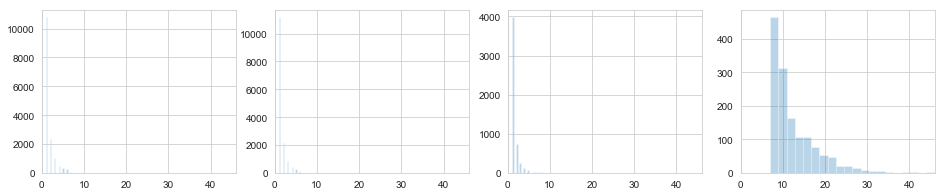

ave_revenue


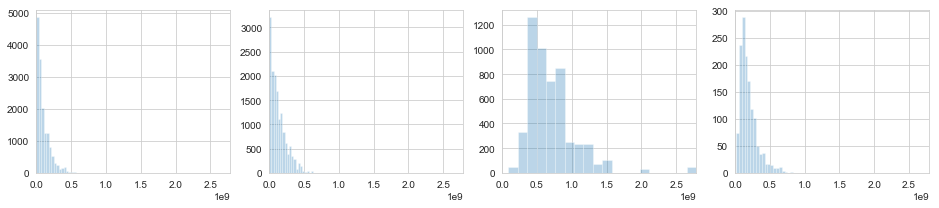

ave_count_vote


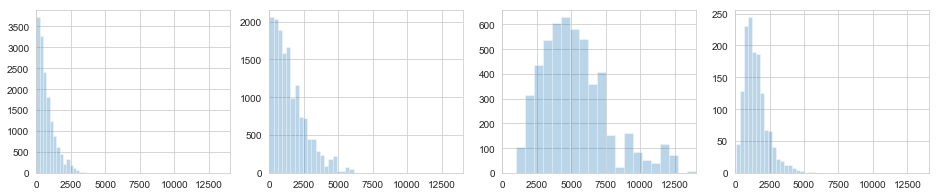

ave_vote


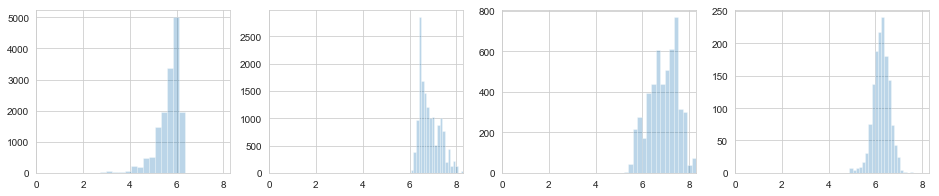

ave_budget


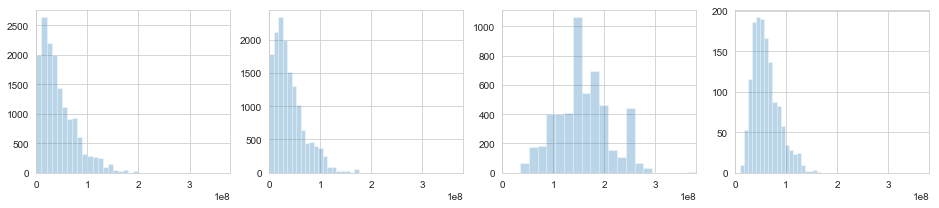

Action


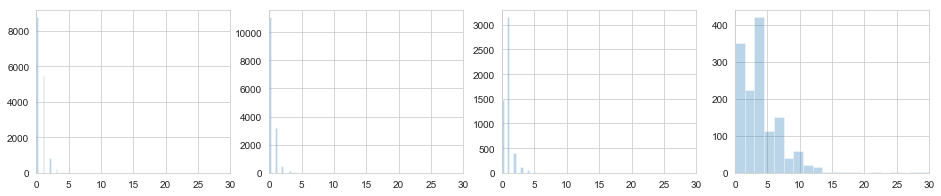

Adventure


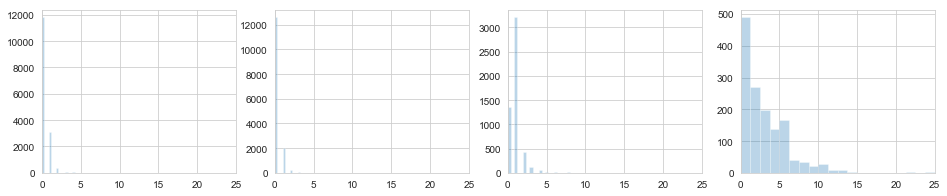

Animation


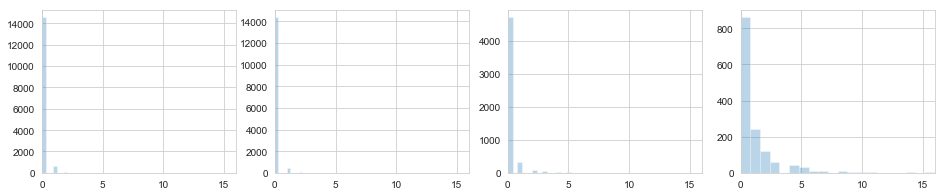

Comedy


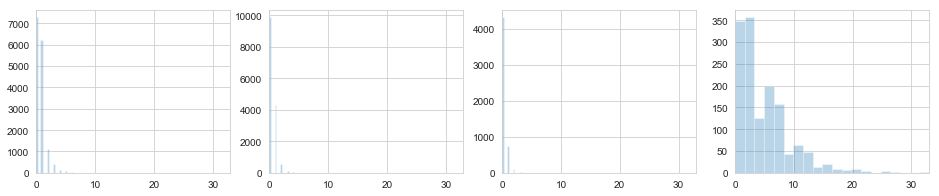

Crime


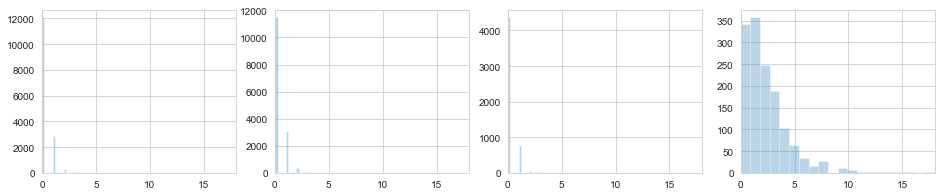

Documentary


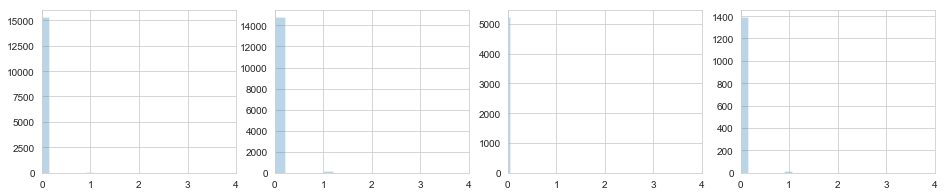

Drama


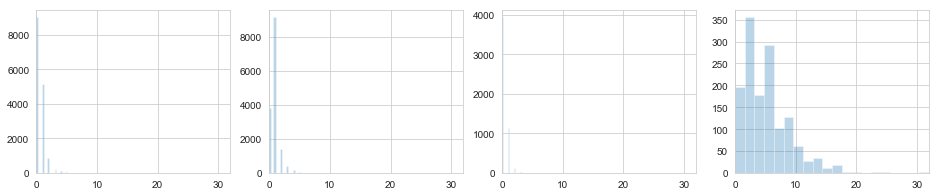

Family


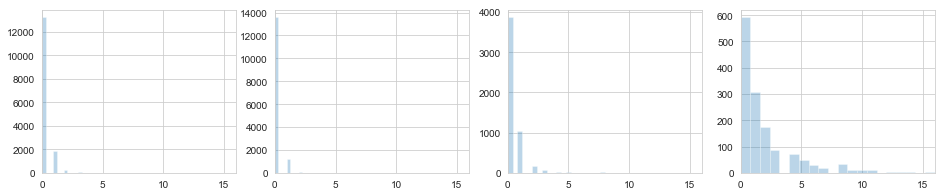

Fantasy


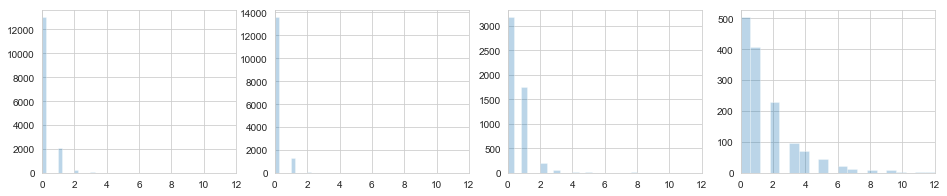

Foreign


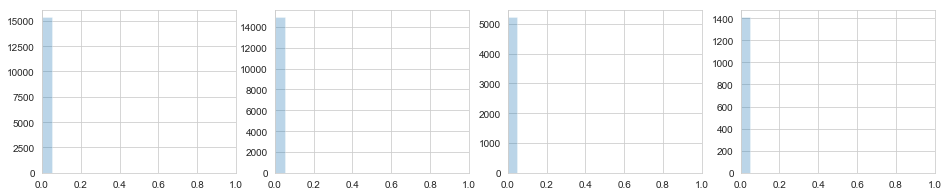

History


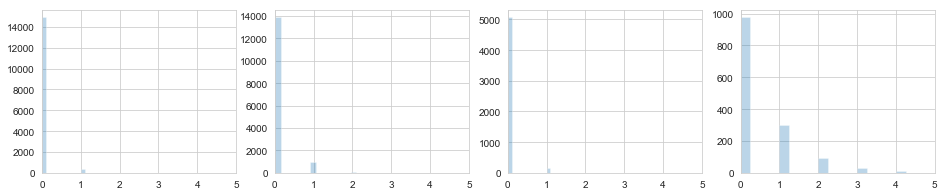

Horror


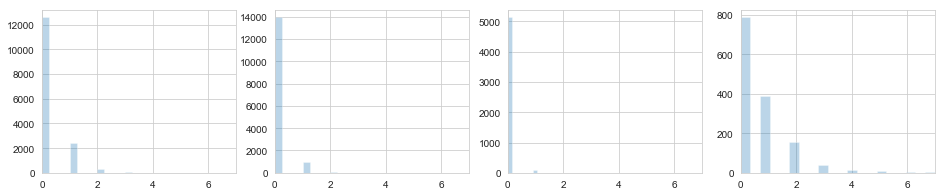

Music


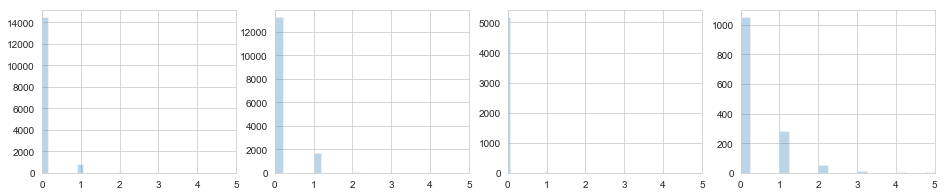

Mystery


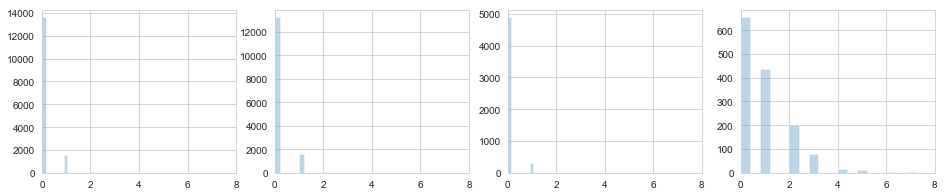

Romance


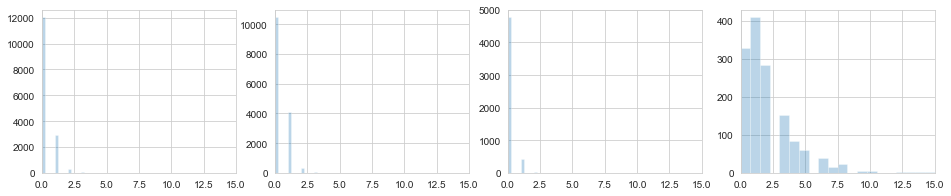

Science Fiction


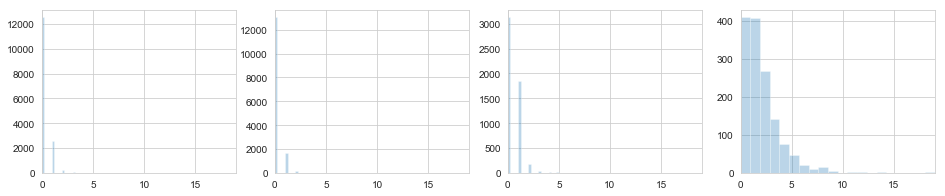

Thriller


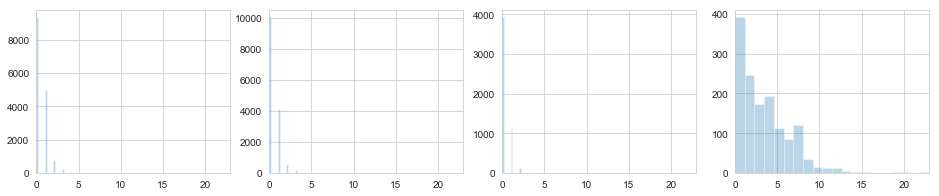

War


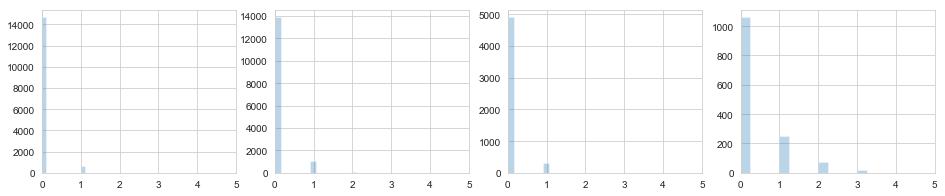

Western


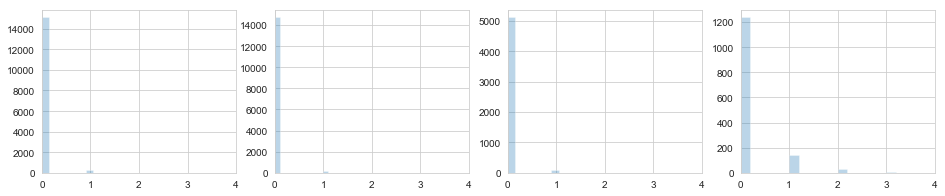

In [56]:
# Analyze the results
df_results = df_results.reset_index()
for cluster in sorted(set(model.labels_)):
    print(collections.Counter(df_results[df_results['cluster']==cluster]['num_movies']).most_common(5))

n_clusters = len(set(model.labels_))
for col in analize_columns:
    print(col)
    i = 1
    plt.figure(figsize=(16,3))
    for cluster in sorted(set(model.labels_)):
        plt.subplot(1, n_clusters, i)
        plt.xlim([0,df_results[col].max()])
        plt.hist(df_results[df_results['cluster']==cluster][col], label=str(cluster), alpha=0.3, bins=20)
        i += 1
    plt.show()

# Model Evaluation

In [53]:
# Inter-Cluster
centroids = []
for cluster in sorted(set(model.labels_)):
    centroids.append(X[X['cluster']==cluster][X_columns].mean().values)
distances = []
for c1 in centroids:
    for c2 in centroids:
        distances.append(euclidean_distances(c1.reshape(-1, 1), c2.reshape(-1, 1))[0][0])
print('Inter Cluster distance', np.mean(distances))

# Intra-Cluster
distances = []
for cluster in sorted(set(model.labels_)):
    df_filter = X[X['cluster']==cluster]
    centroid = df_filter[X_columns].mean().values
    for k, v in df_filter[X_columns].iterrows():
        distances.append(euclidean_distances(centroid.reshape(-1, 1), v.values.reshape(-1, 1))[0][0])
print('Intra Cluster distance', np.mean(distances))

# Inertia
distances = []
for cluster in sorted(set(model.labels_)):
    df_filter = X[X['cluster']==cluster]
    centroid = df_filter[X_columns].mean().values
    for k, v in df_filter[X_columns].iterrows():
        distances.append(euclidean_distances(centroid.reshape(1, -1), v.values.reshape(1, -1), squared=True)[0][0])
print('Inertia', np.sum(distances))

Inter Cluster distance 1.5882619946764107
Intra Cluster distance 0.3460207344377122
Inertia 75025.42356029464


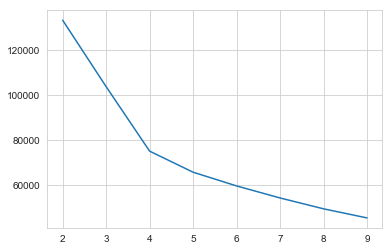

In [54]:
inertia = []
number_k = []
for k in range(2, 10, 1):
    kmeans = KMeans(n_clusters=k).fit(X.values)
    inertia.append(kmeans.inertia_)
    number_k.append(k)
plt.plot(number_k, inertia)
plt.show()

# Hierarchical Model Training 

In [ ]:
import scipy
import scipy.cluster.hierarchy as sch
import collections

In [ ]:
# X = df_act[X_columns]
# X.head()

In [ ]:
# # normalize the data
# for col in X_columns:
#     X[col] = StandardScaler().fit_transform(X[col].values.reshape(-1, 1))

In [ ]:
# k = 3
# color_threshold = 99.
# d = sch.distance.pdist(X[['num_movies', 'sum_count_vote']])
# Z= sch.linkage(d, method = 'ward') # minimize within cluster variation
# T = sch.fcluster(Z, k, 'maxclust')
# P = sch.dendrogram(Z, color_threshold=color_threshold)
# plt.show()

# print(set(T))
# print(collections.Counter(T))

# df_results = df_act.copy()
# df_results['cluster'] = T
# df_act['cluster'] = T

In [ ]:
# # Analyze the results
# for cluster in set(T):
#     print((cluster), (len(df_results[df_results['cluster']==cluster]['name'])))
#     print(sorted(list(df_results[df_results['cluster']==cluster]['name'])))

In [ ]:
# # Analyze the centroids
# df_results.groupby('cluster').mean().round(2).T

In [ ]:
# inertia = []
# number_k = []
# for k in range(2,15,1):
#     d = sch.distance.pdist(X[X_columns])
#     Z= sch.linkage(d, method = 'ward')
#     T = sch.fcluster(Z, k, 'maxclust')
#     df_act['cluster'] = T

#     # Inertia
#     distances = []
#     for cluster in sorted(set(T)):
#         df_filter = df_act[df_act['cluster']==cluster]
#         centroid = df_filter[X_columns].mean().values
#         for _, v in df_filter[X_columns].iterrows():
#             distances.append(euclidean_distances(centroid.reshape(1, -1), v.values.reshape(1, -1), squared=True)[0][0])
#     inertia.append(np.sum(distances))
#     number_k.append(k)
# plt.plot(number_k, inertia)
# plt.show()